<a href="https://colab.research.google.com/github/gggggeun/study/blob/main/Reuters_dataset(%EB%89%B4%EC%8A%A4%EA%B8%B0%EC%82%AC_%EB%8B%A4%EC%A4%91%EB%B6%84%EB%A5%98).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 뉴스 기사 분류 : 로이터(Reuters) 데이터셋

1986년 로이터에서 공개한 짧은 뉴스 기사와 토픽의 집합인 데이터. 

텍스트 분류를 위해 널리 사용되는 간단한 데이터셋으로 46개의 토픽이 있고 어떤 토픽은 다른 것에 비해 데이터가 많다. 

각 토픽은 훈련 세트에 최소한 10개의 샘플을 가지고 있다. 

이 데이터셋은 원본 로이터 데이터셋(135개 토픽) 중 샘플이 많은 것을 뽑아 간단하게 만든 것이다.

defalt값으로 8,982개의 훈련 샘플과 2,246개의 테스트 샘플이 있음.

IMDB, MNIST와 마친가지로 케라스에 포함되어 있다.

IMDB과 마찬가지로 미리 전체 데이터셋의 단어를 고유한 정수 인덱스로 바꾼 후 훈련/테스트 데이터로 나누어 놓았다. 

- 로이터 뉴스를 46개의 상호 배타적인 토픽으로 분류하는 신경망 만들기
- 단일 레이블, 다중 분류 문제.(single-label, multiclass classification)
- 각 데이터 포인트가 여러 개의 범주(ex.토픽)에 속하면 다중 레이블 다중 분류 문제가 된다.

## 데이터 불러오기

In [2]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)  #단어 1만개로 제한

2113536/2110848 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [3]:
print(len(train_data))
print(len(test_data))

8982
2246


In [4]:
print(train_data[10])

[1, 245, 273, 207, 156, 53, 74, 160, 26, 14, 46, 296, 26, 39, 74, 2979, 3554, 14, 46, 4689, 4329, 86, 61, 3499, 4795, 14, 61, 451, 4329, 17, 12]


In [5]:
# 텍스트로 디코딩하기

word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

#0,1,2는 '패딩','문서시작','사전에 없음'음 위한 인덱스이므로 3을 뺸다.
decoded_newswire = ' '.join([reverse_word_index.get(i-3, '?') for i in train_data[0]]) 

557056/550378 [==============================] - 0s 0us/step


In [6]:
decoded_newswire[15:]

' result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

In [7]:
# 토픽의 인덱스 (0~45 사이 정수)
train_labels[10]

3

In [8]:
train_labels.shape

(8982,)

In [9]:
test_labels.shape

(2246,)

## 데이터 전처리

In [10]:
# 벡터화 : trian/test data는 파이썬 리스트의 넘파이 배열이기 때문에 to_categorical()함수 사용 못함.

import numpy as np

def vectorize_sequences(sequences, dimension=10000):
  results = np.zeros((len(sequences), dimension))  #크기가 (len(sequences), dimension)이고 모든 원소가 0인 행렬을 만든다.
  for i, sequence in enumerate(sequences):
    results[i, sequence] = 1.  #results[i]에서 특정 인덱스의 위치를 1로 만든다.
  return results

x_train = vectorize_sequences(train_data)  # 훈련데이터 벡터변환 
x_test = vectorize_sequences(test_data)   # 테스트데이터 벡터변환

레이블을 벡터로 바꾸는 방법 2가지
1. 레이블의 리스트를 정수 텐서로 변환
2. 원-핫 인코딩(범주형 인코딩, categorical encoding)

In [11]:
# 각 레이블의 인덱스자리는 1이고 나머지는 0인 벡터로 변환
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

In [12]:
one_hot_train_labels.shape

(8982, 46)

In [13]:
one_hot_test_labels.shape

(2246, 46)

## 모델 구성

IMDB와 마찬가지로 짧은 텍스트를 분류하는 문제이다. 여기에서는 새로운 제약 사항이 추가되었는데, 출력 클래스의 개수가 2개에서 46개로 늘어난 점이다.

IMDB는 출력의 차원이 작아 16차원을 가진 중간층을 사용할 수 있었지만, 여기에서 16차원 공간은 46개의 클래스를 구분하기에 너무 제약이 많다. 이렇게 규모가 작은 층은 유용한 정보를 완전히 잃게 되는 정보의 병목 지점처럼 동작할 수도 있다.

그런 이유로 좀 더 규모가 큰 층을 사용해야한다. (64개 유닛)

In [14]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

여기서 주목할점
- 마지막 Dense 층 크기 = 46(출력값). 각 입력 샘플에 대해 46차원의 벡터를 출력한다는 뜻. 이 벡터의 각 원소(차원)는 각기 다른 출력 클래스가 인코딩된 것이다.
- 마지막 층 softmax 활성화 함수. 각 입력 샘플마다 46개의 출력 클래스에 대한 확률 분포를 출력함. 즉 46차원의 출력 벡터를 만들며 output[i]는 어떤 샘플이 클래스 i에 속할 확률이다. 값은 모두 확률이며 46개의 값을 모두 더하면 1이 된다.
- 이런 문제에 사용할 최선의 loss_function은 categorical_crossentropy이다. 이 함수는 두 확률 분포 사이의 거리를 측정한다. 여기에서는 네트워크가 출력한 확률 분포와 진짜 레이블의 분포 사이의 거리를 측정한다. 두 분포 사이의 거리를 최소화하면 진짜 레이블에 가능한 가까운 출력을 내도록 모델을 훈련하게 된다.

In [15]:
model.compile(optimizer='rmsprop',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

## 훈련 검증
훈련 데이터에서 1000개의 샘플을 검증 세트로 사용



In [16]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [17]:
#epochs =20

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 2s 95ms/step - loss: 3.1448 - accuracy: 0.3856 - val_loss: 1.7179 - val_accuracy: 0.6390
Epoch 2/20
16/16 [==============================] - 1s 65ms/step - loss: 1.5010 - accuracy: 0.6860 - val_loss: 1.3030 - val_accuracy: 0.7100
Epoch 3/20
16/16 [==============================] - 1s 63ms/step - loss: 1.0641 - accuracy: 0.7704 - val_loss: 1.1418 - val_accuracy: 0.7560
Epoch 4/20
16/16 [==============================] - 1s 60ms/step - loss: 0.8497 - accuracy: 0.8232 - val_loss: 1.0477 - val_accuracy: 0.7780
Epoch 5/20
16/16 [==============================] - 1s 64ms/step - loss: 0.6619 - accuracy: 0.8664 - val_loss: 0.9871 - val_accuracy: 0.7870
Epoch 6/20
16/16 [==============================] - 1s 63ms/step - loss: 0.5605 - accuracy: 0.8877 - val_loss: 0.9686 - val_accuracy: 0.7950
Epoch 7/20
16/16 [==============================] - 1s 64ms/step - loss: 0.4324 - accuracy: 0.9129 - val_loss: 0.9134 - val_accuracy: 0.8060
Epoch 8/20
16

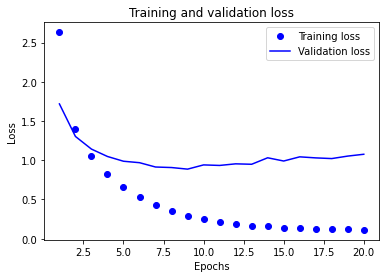

In [18]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss =history.history['val_loss']

epochs = range(1, len(loss) +1 )

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

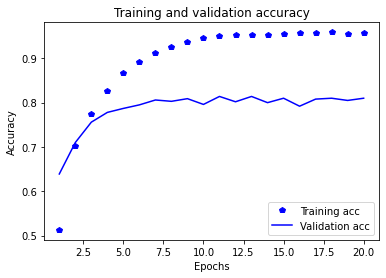

In [19]:
plt.clf()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bp', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

ephochs = 9 로 바꾸기

In [20]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train,
         partial_y_train,
         epochs=9,
         batch_size=512,
         validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 2s 80ms/step - loss: 3.1071 - accuracy: 0.4201 - val_loss: 1.6884 - val_accuracy: 0.6410
Epoch 2/9
16/16 [==============================] - 1s 62ms/step - loss: 1.4786 - accuracy: 0.6960 - val_loss: 1.3164 - val_accuracy: 0.7160
Epoch 3/9
16/16 [==============================] - 1s 66ms/step - loss: 1.0681 - accuracy: 0.7770 - val_loss: 1.1240 - val_accuracy: 0.7660
Epoch 4/9
16/16 [==============================] - 1s 62ms/step - loss: 0.8250 - accuracy: 0.8230 - val_loss: 1.0344 - val_accuracy: 0.7900
Epoch 5/9
16/16 [==============================] - 1s 63ms/step - loss: 0.6649 - accuracy: 0.8578 - val_loss: 0.9876 - val_accuracy: 0.7820
Epoch 6/9
16/16 [==============================] - 1s 62ms/step - loss: 0.5286 - accuracy: 0.8910 - val_loss: 0.9258 - val_accuracy: 0.8130
Epoch 7/9
16/16 [==============================] - 1s 61ms/step - loss: 0.4248 - accuracy: 0.9144 - val_loss: 0.9174 - val_accuracy: 0.8130
Epoch 8/9
16/16 [===

In [21]:
results

[0.9870482683181763, 0.7867319583892822]

정확도 78%.

균형 잡힌 이진 분류 문제에서 완전히 무작위로 분류하면 50%의 정확도를 달성한다.
이 문제는 불균형한 데이터셋을 사용하므로 무작위로 분류하면 18% 정도를 달성한다.

In [22]:
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
float(np.sum(hits_array)) / len(test_labels)

0.18833481745325023

## 새로운 데이터에 대해 예측하기

In [23]:
predictions = model.predict(x_test)

In [24]:
predictions[0].shape

(46,)

In [25]:
# 벡터의 원소 합 =1
np.sum(predictions[0])

1.0

In [26]:
# 가장 확률이 높은 클래스
np.argmax(predictions[0])

3

## 레이블과 손실을 다루는 다른 방법

레이블 인코딩 또 다른 방법 : 정수 텐서로 변환

정수 레이블을 사용할 경우는 sparse_categorical_crossentropy를 사용할 수 있음.
(원핫인코딩 사용 시 categorical_crossentropy를 사용했음.)

In [28]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [31]:
model.compile(optimizer="rmsprop",
             loss = 'sparse_categorical_crossentropy',
             metrics=['acc'])

## 충분히 큰 중간층을 두어야 하는 이유

앞서 언급한 것처럼 마지막 출력이 46차원이기 때문에 중간층의 히든 유닛이 46개보다 많이 적어서는 안된다.  46차원보다 훨씬 작은 중간층(ex.4차원)을 두면 정보의 병목이 어떻게 나타나는지 확인해보자.

In [32]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train,
         partial_y_train,
         epochs=20,
         batch_size=512,
         validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/20
16/16 [==============================] - 2s 73ms/step - loss: 3.4926 - accuracy: 0.1035 - val_loss: 2.8185 - val_accuracy: 0.5650
Epoch 2/20
16/16 [==============================] - 1s 51ms/step - loss: 2.6504 - accuracy: 0.5641 - val_loss: 2.2693 - val_accuracy: 0.5530
Epoch 3/20
16/16 [==============================] - 1s 49ms/step - loss: 2.1221 - accuracy: 0.5647 - val_loss: 1.9372 - val_accuracy: 0.5650
Epoch 4/20
16/16 [==============================] - 1s 50ms/step - loss: 1.8136 - accuracy: 0.5750 - val_loss: 1.7242 - val_accuracy: 0.5800
Epoch 5/20
16/16 [==============================] - 1s 54ms/step - loss: 1.6093 - accuracy: 0.5873 - val_loss: 1.5970 - val_accuracy: 0.5960
Epoch 6/20
16/16 [==============================] - 1s 61ms/step - loss: 1.4426 - accuracy: 0.6042 - val_loss: 1.5375 - val_accuracy: 0.6010
Epoch 7/20
16/16 [==============================] - 1s 60ms/step - loss: 1.3376 - accuracy: 0.6241 - val_loss: 1.4470 - val_accuracy: 0.6380
Epoch 8/20
16

- val_accuracy의 최고값은 71%로 이전보다 약 7~8% 감소되었다.(78%였음.)

이런 손실의 원인 대부분은 많은 정보(클래스 46개의 분할 초평면을 복원하기에 충분한 정보)를 중간층의 저차원 표현 공간으로 압축하려고 했기 때문이다. 이 네트워크는 필요한 정보 대부분을 4차원 표현 안에 구겨 넣었지만 전부는 넣지 못했다.

## 추가실험
- 더 크거나 작은 층 사용하기 (32, 128개 유닛)
- 1개나 3개의 은닉 층 사용해보기

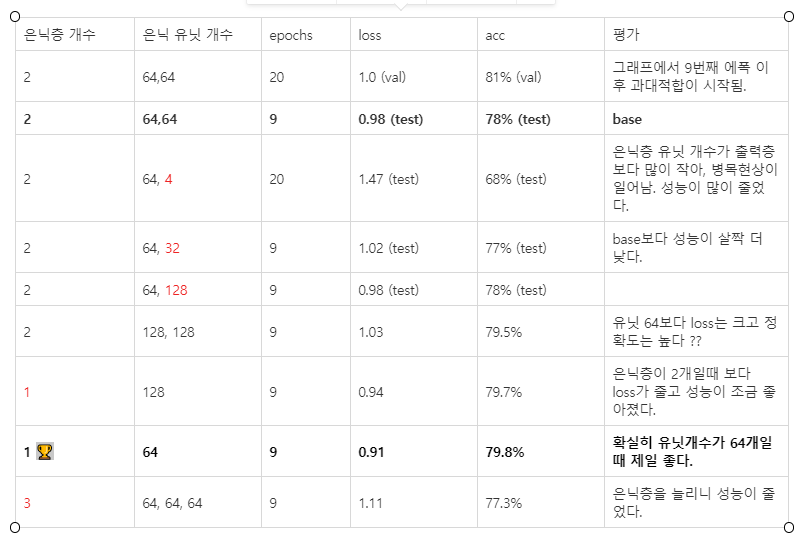

최적 : 은닉층이 1개, 유닛 개수 64개 사용 할 때

In [38]:
# 32유닛
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train,
         partial_y_train,
         epochs=9,
         batch_size=512,
         validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 2s 63ms/step - loss: 3.2620 - accuracy: 0.3483 - val_loss: 2.0721 - val_accuracy: 0.6390
Epoch 2/9
16/16 [==============================] - 1s 64ms/step - loss: 1.8004 - accuracy: 0.6829 - val_loss: 1.4733 - val_accuracy: 0.6920
Epoch 3/9
16/16 [==============================] - 1s 62ms/step - loss: 1.2266 - accuracy: 0.7521 - val_loss: 1.2211 - val_accuracy: 0.7440
Epoch 4/9
16/16 [==============================] - 1s 54ms/step - loss: 0.9437 - accuracy: 0.8118 - val_loss: 1.1055 - val_accuracy: 0.7710
Epoch 5/9
16/16 [==============================] - 1s 52ms/step - loss: 0.7411 - accuracy: 0.8544 - val_loss: 1.0278 - val_accuracy: 0.7870
Epoch 6/9
16/16 [==============================] - 1s 50ms/step - loss: 0.6240 - accuracy: 0.8756 - val_loss: 0.9823 - val_accuracy: 0.7980
Epoch 7/9
16/16 [==============================] - 1s 50ms/step - loss: 0.5157 - accuracy: 0.8942 - val_loss: 0.9466 - val_accuracy: 0.8140
Epoch 8/9
16/16 [===

In [39]:
# 128유닛
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train,
         partial_y_train,
         epochs=9,
         batch_size=512,
         validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 1s 61ms/step - loss: 3.0900 - accuracy: 0.4379 - val_loss: 1.6062 - val_accuracy: 0.6600
Epoch 2/9
16/16 [==============================] - 1s 50ms/step - loss: 1.3835 - accuracy: 0.7140 - val_loss: 1.2505 - val_accuracy: 0.7400
Epoch 3/9
16/16 [==============================] - 1s 51ms/step - loss: 1.0043 - accuracy: 0.7927 - val_loss: 1.1002 - val_accuracy: 0.7760
Epoch 4/9
16/16 [==============================] - 1s 51ms/step - loss: 0.7685 - accuracy: 0.8440 - val_loss: 1.0044 - val_accuracy: 0.8030
Epoch 5/9
16/16 [==============================] - 1s 49ms/step - loss: 0.6035 - accuracy: 0.8710 - val_loss: 0.9612 - val_accuracy: 0.8150
Epoch 6/9
16/16 [==============================] - 1s 50ms/step - loss: 0.4941 - accuracy: 0.8969 - val_loss: 0.9196 - val_accuracy: 0.8080
Epoch 7/9
16/16 [==============================] - 1s 51ms/step - loss: 0.3799 - accuracy: 0.9198 - val_loss: 0.9093 - val_accuracy: 0.8130
Epoch 8/9
16/16 [===

In [40]:
# 128,128유닛
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train,
         partial_y_train,
         epochs=9,
         batch_size=512,
         validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 2s 100ms/step - loss: 2.8564 - accuracy: 0.4217 - val_loss: 1.4065 - val_accuracy: 0.7040
Epoch 2/9
16/16 [==============================] - 1s 88ms/step - loss: 1.1998 - accuracy: 0.7468 - val_loss: 1.1100 - val_accuracy: 0.7620
Epoch 3/9
16/16 [==============================] - 1s 85ms/step - loss: 0.8401 - accuracy: 0.8198 - val_loss: 0.9848 - val_accuracy: 0.7960
Epoch 4/9
16/16 [==============================] - 1s 84ms/step - loss: 0.5968 - accuracy: 0.8752 - val_loss: 0.9128 - val_accuracy: 0.8140
Epoch 5/9
16/16 [==============================] - 1s 77ms/step - loss: 0.4117 - accuracy: 0.9159 - val_loss: 0.8666 - val_accuracy: 0.8270
Epoch 6/9
16/16 [==============================] - 1s 78ms/step - loss: 0.3265 - accuracy: 0.9333 - val_loss: 0.8930 - val_accuracy: 0.8190
Epoch 7/9
16/16 [==============================] - 1s 88ms/step - loss: 0.2372 - accuracy: 0.9480 - val_loss: 0.8988 - val_accuracy: 0.8070
Epoch 8/9
16/16 [==

In [41]:
# 128,128유닛
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train,
         partial_y_train,
         epochs=9,
         batch_size=512,
         validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 2s 97ms/step - loss: 2.7107 - accuracy: 0.4777 - val_loss: 1.4304 - val_accuracy: 0.7010
Epoch 2/9
16/16 [==============================] - 1s 80ms/step - loss: 1.1734 - accuracy: 0.7588 - val_loss: 1.0974 - val_accuracy: 0.7830
Epoch 3/9
16/16 [==============================] - 1s 77ms/step - loss: 0.7810 - accuracy: 0.8443 - val_loss: 0.9586 - val_accuracy: 0.7920
Epoch 4/9
16/16 [==============================] - 1s 75ms/step - loss: 0.5772 - accuracy: 0.8856 - val_loss: 0.8688 - val_accuracy: 0.8250
Epoch 5/9
16/16 [==============================] - 1s 76ms/step - loss: 0.4307 - accuracy: 0.9170 - val_loss: 0.8346 - val_accuracy: 0.8280
Epoch 6/9
16/16 [==============================] - 1s 75ms/step - loss: 0.3317 - accuracy: 0.9326 - val_loss: 0.8105 - val_accuracy: 0.8260
Epoch 7/9
16/16 [==============================] - 1s 75ms/step - loss: 0.2581 - accuracy: 0.9436 - val_loss: 0.8222 - val_accuracy: 0.8230
Epoch 8/9
16/16 [===

In [42]:
# 64유닛
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train,
         partial_y_train,
         epochs=9,
         batch_size=512,
         validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 1s 64ms/step - loss: 2.9942 - accuracy: 0.4846 - val_loss: 1.7698 - val_accuracy: 0.6590
Epoch 2/9
16/16 [==============================] - 1s 51ms/step - loss: 1.5489 - accuracy: 0.7104 - val_loss: 1.3389 - val_accuracy: 0.7240
Epoch 3/9
16/16 [==============================] - 1s 49ms/step - loss: 1.1010 - accuracy: 0.7865 - val_loss: 1.1437 - val_accuracy: 0.7520
Epoch 4/9
16/16 [==============================] - 1s 49ms/step - loss: 0.8469 - accuracy: 0.8390 - val_loss: 1.0175 - val_accuracy: 0.7930
Epoch 5/9
16/16 [==============================] - 1s 48ms/step - loss: 0.6877 - accuracy: 0.8674 - val_loss: 0.9509 - val_accuracy: 0.8040
Epoch 6/9
16/16 [==============================] - 1s 48ms/step - loss: 0.5462 - accuracy: 0.8940 - val_loss: 0.8952 - val_accuracy: 0.8150
Epoch 7/9
16/16 [==============================] - 1s 49ms/step - loss: 0.4558 - accuracy: 0.9084 - val_loss: 0.8664 - val_accuracy: 0.8220
Epoch 8/9
16/16 [===

In [45]:
# 64유닛 은닉층 3개
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train,
         partial_y_train,
         epochs=9,
         batch_size=512,
         validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 2s 62ms/step - loss: 3.1326 - accuracy: 0.4335 - val_loss: 1.6683 - val_accuracy: 0.6370
Epoch 2/9
16/16 [==============================] - 1s 50ms/step - loss: 1.4470 - accuracy: 0.6886 - val_loss: 1.3550 - val_accuracy: 0.6890
Epoch 3/9
16/16 [==============================] - 1s 49ms/step - loss: 1.1050 - accuracy: 0.7478 - val_loss: 1.2455 - val_accuracy: 0.7120
Epoch 4/9
16/16 [==============================] - 1s 49ms/step - loss: 0.8897 - accuracy: 0.8034 - val_loss: 1.1506 - val_accuracy: 0.7430
Epoch 5/9
16/16 [==============================] - 1s 49ms/step - loss: 0.6894 - accuracy: 0.8474 - val_loss: 1.0585 - val_accuracy: 0.7870
Epoch 6/9
16/16 [==============================] - 1s 49ms/step - loss: 0.5449 - accuracy: 0.8827 - val_loss: 1.0215 - val_accuracy: 0.7900
Epoch 7/9
16/16 [==============================] - 1s 50ms/step - loss: 0.4381 - accuracy: 0.9052 - val_loss: 1.0187 - val_accuracy: 0.8050
Epoch 8/9
16/16 [===